In [1]:
import pandas as pd
df = pd.read_csv('/Users/emilianopenaloza/Git/TwitterControl/DyGLib/processed_data/CanParl/ml_CanParl.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/emilianopenaloza/Git/TwitterControl/DyGLib/processed_data/CanParl/ml_CanParl.csv'

## Generate Synthetic


In [ ]:
import networkx as nx
import numpy as np
from statistics import mean 
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")



In [ ]:
class BLock_model():
    def __init__(self,n_nodes, n_communities, cov_dictionary , means_dictionary , num_feats) -> None:

        self.arr = np.zeros((n_nodes,num_feats))
        self.n_nodes = n_nodes
        self.nodes_per_community = int(np.floor(n_nodes/ n_communities))
        cur_nodes = 0
        for c in range(n_communities):
            x= np.random.multivariate_normal(means_dictionary[c], cov_dictionary[c], self.nodes_per_community )

            self.arr[cur_nodes:cur_nodes + self.nodes_per_community,:] = x
            cur_nodes += self.nodes_per_community

        self.labels = {i: (lambda x: 0 if x> self.nodes_per_community  else 1)(i) for i in range(n_nodes)}
        self.colors = {i: (lambda x: 'red' if x> self.nodes_per_community  else 'blue')(i) for i in range(self.n_nodes)}
        self.G =nx.Graph()
        nx.set_node_attributes(self.G, dict(zip(self.G.nodes(), self.arr)), 'features')
        nx.set_node_attributes(self.G, {i: (lambda x: 'red' if x> self.nodes_per_community else 'blue')(i) for i in range(self.n_nodes)}, 'color')
        nx.set_node_attributes(self.G, {i: (lambda x: 0 if x> self.nodes_per_community else 1)(i) for i in range(self.n_nodes)}, 'label')

    
    def get_distances(self):
        distances = np.zeros((self.arr.shape[0],self.arr.shape[0]))
        for i in range(self.arr.shape[0]): 
            for j in range(self.arr.shape[0]):
                u = self.arr[i,: ]
                v = self.arr[j,:]
                distance = np.linalg.norm(u - v)
                distances[i,j] = distance
        return (distances - np.min(distances))/(np.max(distances) - np.min(distances))
            
            


    def generate_Graph(self,thresh = .1 , inter_community_p =  .9 , outer_community_p = .4, close_features_p= .3):
        G= nx.Graph()
        distances = self.get_distances()
        def add_edge(i,j): 
            self.G.add_edge(i,j) 
            self.G.add_edge(j,i)
        for i in range(self.arr.shape[0]): 
            for j in range(self.arr.shape[0]):
                if i ==j:
                    continue
                distance = distances[i,j]
                r = np.random.uniform(0,1)
                if distance < thresh: # if the covariates are close it influences the probability of forming an edge
                    if self.labels[i] != self.labels[j]: # not in same community
                        if outer_community_p>r :
                            add_edge(i,j)
                    else: # in the same community
                        if  inter_community_p > r: 
                            add_edge(i,j)
                else:  # if covariates are further apart this decreases the probability of not forming an edge

                    if   close_features_p > r :
                        add_edge(i,j)
                 

        nx.set_node_attributes(self.G, dict(zip(self.G.nodes(), self.arr)), 'features')
        nx.set_node_attributes(self.G, {i: (lambda x: 'red' if x> self.nodes_per_community else 'blue')(i) for i in range(self.n_nodes)}, 'color')
        nx.set_node_attributes(self.G, {i: (lambda x: 0 if x> self.nodes_per_community else 1)(i) for i in range(self.n_nodes)}, 'label')


    def set_node_features(self):
        nx.set_node_attributes(self.G, dict(zip(self.G.nodes(), self.arr)), 'features')
        nx.set_node_attributes(self.G, {i: (lambda x: 'red' if x> self.nodes_per_community else 'blue')(i) for i in range(self.n_nodes)}, 'color')
        nx.set_node_attributes(self.G, {i: (lambda x: 0 if x> self.nodes_per_community else 1)(i) for i in range(self.n_nodes)}, 'label')
        

    def get_edges_and_attributes(self,ts):
        edge_list = nx.to_pandas_edgelist(self.G)
        attr = pd.DataFrame.from_dict(dict(self.G.nodes(data=True)), orient='index')

        for j in range(attr.iloc[:,0].shape[0]):
            # print(f"==>> {attr.iloc[:,j]=} \n {attr=}")
            attr[f'x{j}'] = pd.Series([x[0] for x in attr.iloc[:,0]])

        attr = attr.drop(columns = ['features'])
        edge_list['ts'] = pd.Series([ts for k in range(len(edge_list))])
        
        return edge_list,attr[['x1','x2']].to_numpy()
    
    def draw(self):
        nx.draw(self.G, pos = nx.spring_layout(self.G), with_labels=True, node_color = [x for x in self.colors.values()])
        plt.show()

    def hist(self,ax,ts = None):
        # compute the degree distribution

        degree_sequence = sorted([d for n, d in self.G.degree()], reverse=True)
        # print(f"==>> {degree_sequence=}")
        degree_counts = nx.degree_histogram(self.G)

        # plot the histogram
        # ax.bar(range(len(degree_counts)), degree_counts)
        ax.hist(degree_sequence)
        # ax.set_xlim(np.min(degree_counts))

        # ax.xlabel('Degree')
        # ax.ylabel('Count')
        ax.set_title(f'Average Degree = {np.mean(degree_sequence): .2f} with the minium degree = {np.min(degree_sequence)} at ts={ts }')
        # print(f"==>> {np.mean(degree_counts)=}")
        # print(f"==>> {degree_counts=}")

                


# mean = [-5, -10]
# cov = [[1, .5], [.5, 2]]


# mean2 = [5, 10]
# cov2 = [[1, 3], [3, 7]]
 
mean = [1]
cov = [[0]]
mean2 = [0]
cov2 = [[0]]
 
means = [mean, mean2]
covs = [cov,cov2]

means_dictionary = {i:x for i,x in enumerate(means)}
cov_dictionary = {i:x for i,x in enumerate(covs)}

block = BLock_model(10,2 ,cov_dictionary,means_dictionary, 1)

block.generate_Graph()
# block.get_edges_and_attributes(0)

In [ ]:
import random

def modify_edges(G, p1= .8, p2 = .4, p3 = .6 ,p4 = .2,threshold=.1,num_nodes = 100,means =[[3,1],[-3,-3]], covs=[[[3, 0], [0, 2]], [[3, 0], [0, 2]]] ):

    means_dictionary = {i:x for i,x in enumerate(means)}
    cov_dictionary = {i:x for i,x in enumerate(covs)}
    new_block = BLock_model(num_nodes,2 ,cov_dictionary,means_dictionary, 2)

    new_distnaces = new_block.get_distances()
    # print(new_distnaces.shape)
    # plt.hist(new_distnaces.flatten()[:100])
    # raise Exception
    for u in G.nodes():
        for v in G.nodes():
            if u == v:
                continue
            # print(u)
            # Check if u and v are in the same community
            if G.has_edge(u, v) and G.nodes[u]['label'] == G.nodes[v]['label']:
                # Move forward edges with probability p1
                if random.random() < p1:
                    new_block.G.add_edge(u, v) 
                
            elif G.has_edge(u, v):
                # Move forward edges with probability p2
                if random.random() < p2:
                    new_block.G.add_edge(u, v)
                
            # Check if u and v do not have an edge and their current feature is below a certain value
            if not G.has_edge(u, v) and new_distnaces[u,v] < threshold :
                if G.nodes[u]['label'] == G.nodes[v]['label']:
                    if random.random() < p3:
                        new_block.G.add_edge(u, v)
                else:
                    if random.random() < p4:
                        new_block.G.add_edge(u, v)

    return new_block
new_block = modify_edges(block.G)

{0: [5, 1], 1: [-5, -1]}


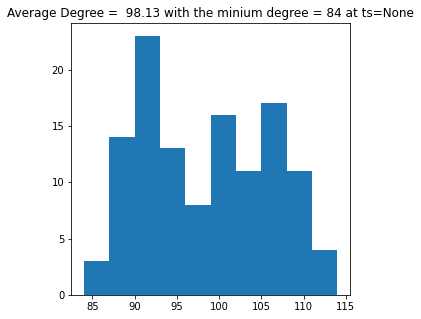

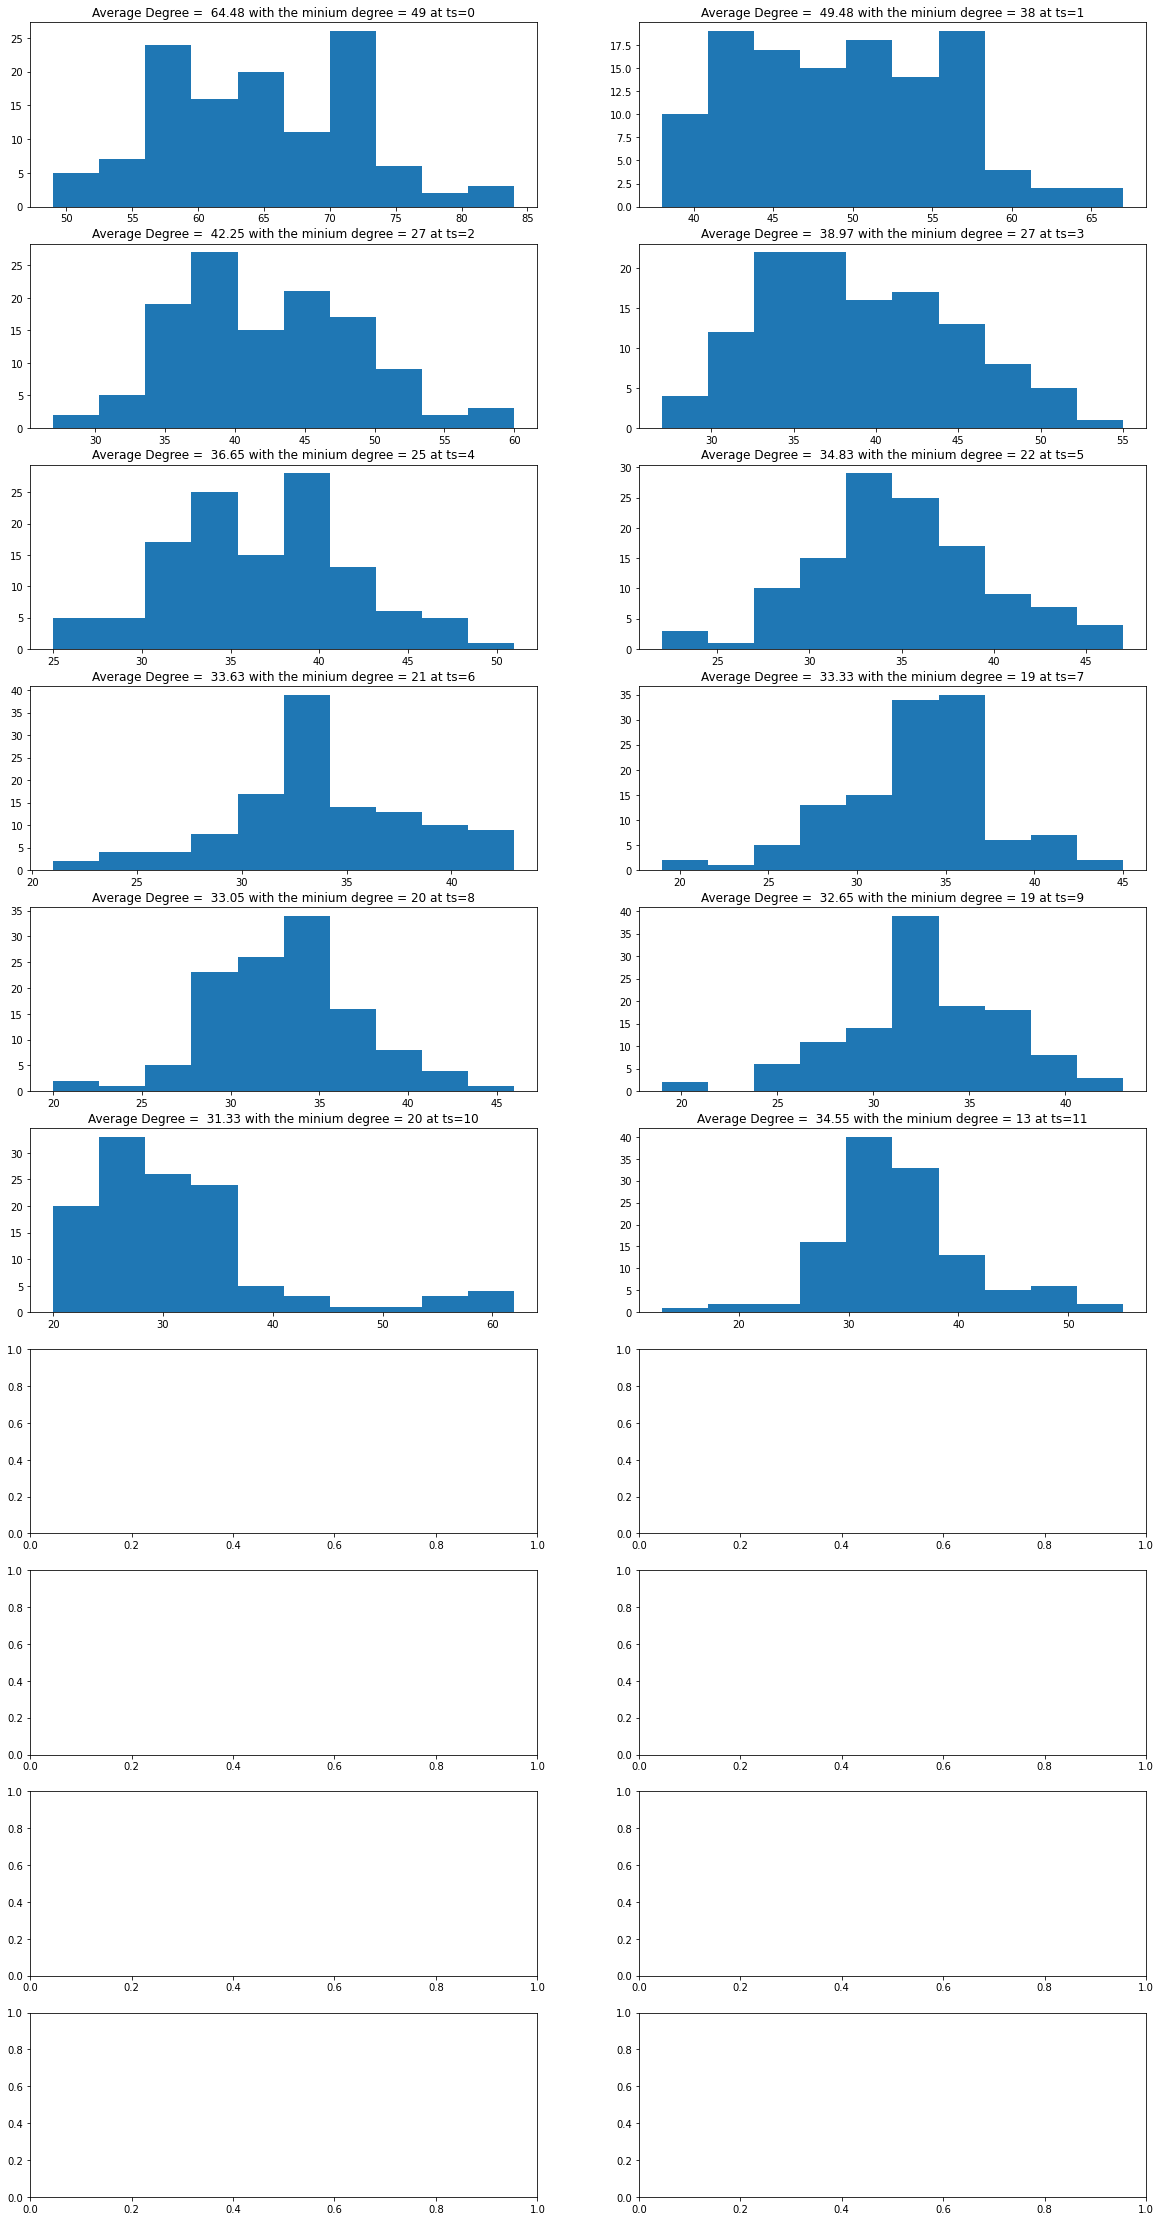

In [ ]:
import pandas as pd
mean = [5, 1]
cov = [[3, 0], [0, 2]]
mean2 = [-5, -1]
cov2 = [[3, 0], [0, 2]]
# mean2 = [0, 4]
# cov2 = [[1, 0], [0, 1]]

means = [mean, mean2]
covs = [cov,cov2]

# new_mean = [1, 0]
# new_cov = [[2, 0], [0, 1]]
# new_mean2 = [-1, 0]
# new_cov2 = [[2, 0], [0, 1]]
new_mean = [5, 1]
new_cov = [[3, 0], [0, 2]]
new_mean2 = [-5, -1]
new_cov2 = [[3, 0], [0, 2]]
# mean2 = [0, 4]
# cov2 = [[1, 0], [0, 1]]

means2 = [new_mean, new_mean2]
covs2 = [new_cov,new_cov2]

means_dictionary = {i:x for i,x in enumerate(means)}
cov_dictionary = {i:x for i,x in enumerate(covs)}
print(means_dictionary)

edges_all = pd.DataFrame()
attr_all = []
num_nodes = 120
base_block = BLock_model(num_nodes,2 ,cov_dictionary,means_dictionary, 2)
base_block.generate_Graph(thresh = .1 , inter_community_p =  .7 , outer_community_p = .05, close_features_p= .75)
fig,ax = plt.subplots(1,1 , figsize = (5,5))
base_block.hist(ax)
plt.show()
prev_edges,previous = base_block.get_edges_and_attributes(0)
edge_lists = []
graphs = runs = 20
runs = 12
fig,ax = plt.subplots(int(graphs/2),2 , figsize = (20,40))

for i in range(graphs ):
    if i == runs:
        break


    new_block =  modify_edges(base_block.G,num_nodes = num_nodes,p1= .75 if i < graphs/2 else 0 ,p2 = .25 if i < graphs/2 else 0\
                              , p3 = .1 if i < graphs/2 else .95, p4 = .05 if i < graphs/2 else .95 ,threshold=.1 if i < graphs/2 else .4,\
                                  means = means if i < graphs/2 else means2 , covs = covs if i < graphs/2 else covs2)
    new_block.set_node_features()
    edges,attr = new_block.get_edges_and_attributes(i)
    new_block.hist(ax = ax.flatten()[i], ts = i )
    
    previous = attr
    prev_edges = edges

    edge_lists.append(edges)
    if i == 0 :
        attr_all = attr
    else:
        attr_all = np.vstack([attr_all,attr])
    base_block = new_block
edges_all = pd.concat(edge_lists,axis = 0)
# print(attr_all.shape)
attr_all = attr_all.reshape((runs,num_nodes,2))

base = '/home/emiliano/projects/def-cbravo/emiliano/DyGLib/processed_data/Synthetic/'
edges_all= edges_all.rename(columns = {'source': 'u','target':'i'})
edges_all['idx'] = pd.Series([ x for x in range(len(edges_all))])
edges_all['label'] = pd.Series([ 0 for x in range(len(edges_all))])

edges_all.to_csv(f'{base}/ml_Synthetic.csv',index=False)
np.save(f'{base}/ml_Synthetic_node.npy',attr_all)
edge_attr = np.ones(len(edges_all)).reshape(-1,1)
np.save(f'{base}/ml_Synthetic.npy',edge_attr)

## Embedding Generation Block

In [ ]:
import pickle as pkl
def genetare_dict():
    return defaultdict(list)
with open('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/embedding_file.pkl' , 'rb') as f :

    embedding_dict = pkl.load(f)

In [ ]:
embedding_dict[0][0][0].shape

(172,)

In [ ]:
import numpy as np
num_feats = embedding_dict[0][0][0].shape[0]
embeddings = np.zeros((len(embedding_dict.keys()),120, num_feats))

In [ ]:
for ts in embedding_dict.keys():
    for u in embedding_dict[ts].keys():
        try:
            embeddings[ts,u,:] = embedding_dict[ts][u][0]
        except Exception as e:
            print(embedding_dict[ts][u][0])
            raise Exception


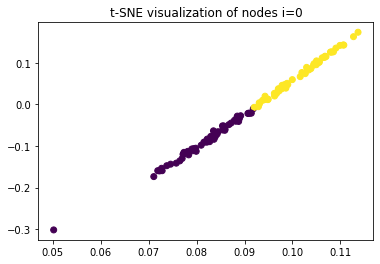

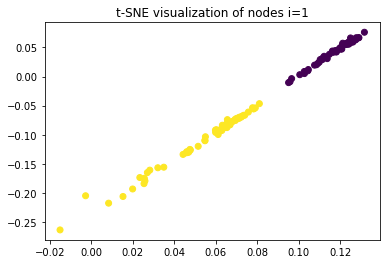

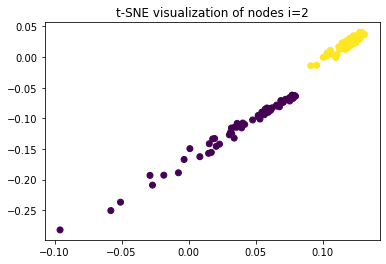

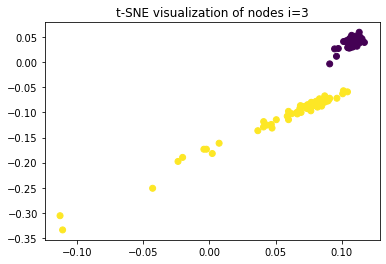

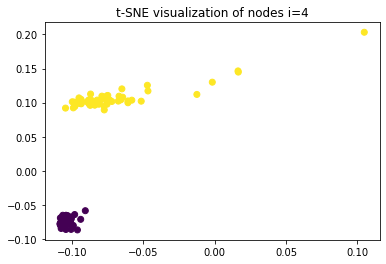

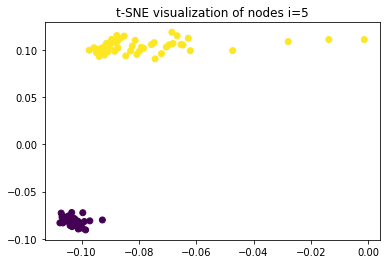

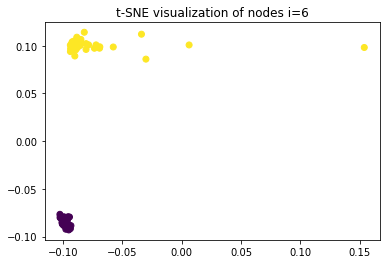

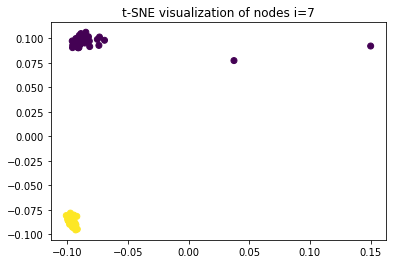

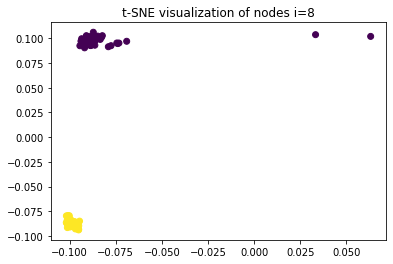

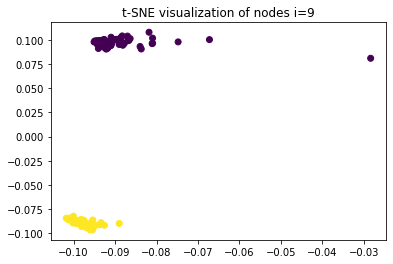

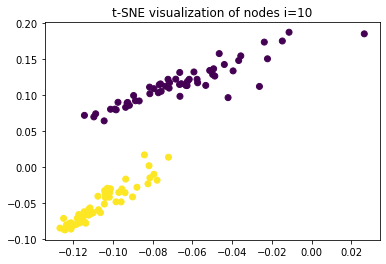

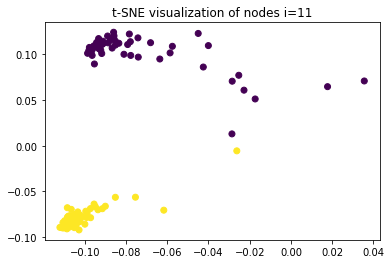

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
for i in range(embeddings.shape[0]):
    # Generate some example data
    nodes = embeddings[i,:,:]  # 100 nodes with 10 features each
    # Create a mask where the rows are all equal to the value
    mask = np.all(nodes == 0, axis=1)

# Use the mask to exclude the rows
    nodes = nodes[~mask]

    # Create a t-SNE object and fit the data
    # tsne = TSNE(n_components=2)
    U, S, V = np.linalg.svd(nodes)
    nodes_tsne = U[:,:2]
    # nodes_tsne = tsne.fit_transform(nodes)

    # Apply k-means clustering with k=3
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(nodes_tsne)
    cluster_labels = kmeans.labels_

    # Visualize the data, colored by cluster labels
    plt.scatter(nodes_tsne[:, 0], nodes_tsne[:, 1], c=cluster_labels)
    plt.title(f"t-SNE visualization of nodes {i=}")
    plt.show()


In [1]:
import re
import json
import networkx as nx
import os

In [2]:
venues = ['neural information processing systems','international conference on machine learning', 'Transactions on Pattern Analysis and Machine Intelligence','NIPS','NeurIPS','CVPR',
          'Neural Networks','knowledge discovery and data mining','kdd','international conference on data mining','Data Mining and Knowledge Discovery', 'icde','icdm','sigmod','PVLDB'
          'international conference on data engineering','Transactions on Knowledge and Data Engineering','Transactions on Database Systems', 'information system','SIGMOD','VLDB',
          'Very Large Data Bases','International Conference on Database Theory']

In [3]:
venues = ['neural information processing systems','international conference on machine learning', 'Transactions on Pattern Analysis and Machine Intelligence','NIPS','NeurIPS','CVPR',
          'Neural Networks','knowledge discovery and data mining','kdd','international conference on data mining','Data Mining and Knowledge Discovery', 'icde','icdm','sigmod','PVLDB',
          'international conference on data engineering','Transactions on Knowledge and Data Engineering','Transactions on Database Systems', 'information system','SIGMOD','VLDB',
          'Very Large Data Bases','International Conference on Database Theory']

ai_venues = ['neural information processing systems', 'international conference on machine learning', 'Transactions on Pattern Analysis and Machine Intelligence', 'NIPS', 'NeurIPS', 'CVPR', 'Neural Networks']
dm_venues = ['knowledge discovery and data mining', 'kdd', 'international conference on data mining', 'Data Mining and Knowledge Discovery']
de_venues = ['icde', 'icdm', 'sigmod', 'PVLDB', 'international conference on data engineering', 'Transactions on Knowledge and Data Engineering', 'Transactions on Database Systems', 'information system', 'SIGMOD', 'VLDB', 'Very Large Data Bases', 'International Conference on Database Theory']

venue_fields = {}
for venue in venues:
    if venue in ai_venues:
        venue_fields[venue.lower()] = 'Artificial Intelligence'
    elif venue in dm_venues:
        venue_fields[venue.lower()] = 'Data Mining'
    elif venue in de_venues:
        venue_fields[venue.lower()] = 'Data Engineering/Management Systems'
    else:
        venue_fields[venue] = 'Unknown Field'


In [4]:
data = []
c = 0 
seen_venues  =set()
running_count = 0 
venues = [x.lower() for x in venues]

with open('dblp_v14.json', 'r') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        try:
            
            line = lines[i][:-2] # line 1114874 is at index 1114873 because lists are 0-indexed
            # print(line)
            line = json.loads(line)
            match = re.search(r'\b(?:' + '|'.join(venues) + r')\b', line['venue']['raw'], flags=re.IGNORECASE)


            if 'venue' in line and 'raw' in line['venue'] and match:
                venue_match = venues[venues.index(match.group(0).lower())]
         

                line['venue']['raw'] = venue_fields[venue_match]
                data.append(line)
                seen_venues.add(line['venue']['raw'])
                current_count = len(seen_venues)
                if current_count > running_count  : 
                    if current_count %10 == 0:
                        print(seen_venues)
                    running_count +=1 

                # print(f"{len(data)=}")
        except Exception as e:
            c+=1 
            if c % 10 == 0:
                print(c)
                print(e)
                raise Exception
            continue



In [5]:

from collections import defaultdict
# Initialize network
Gs= defaultdict(lambda : nx.Graph())

# Add nodes and node attributes
k = 0 
for item in data:
        if 'authors' in item: 
            authors = item['authors']
            venue = item['venue']['raw']
            

            year = item['year']
            abstract = item['abstract'] if  'abstract' in  item else None
            G = Gs[year]
            for author_json in authors:
                author = author_json['name']
                if not G.has_node(author):
                    G.add_node(author, venue=venue, year=[year])
                
                

# Add edges and edge attributes
for item in data:

    if 'authors' in item :
        authors = item['authors']
        year = item['year']
        G = Gs[year]
        for i in range(len(authors)):
            for j in range(i+1, len(authors)):
                if not G.has_edge(authors[i]['name'], authors[j]['name']):
                    G.add_edge(authors[i]['name'], authors[j]['name'], year=[year])



In [11]:

for k in sorted(list(Gs.keys()),reverse=True ):
    G = Gs[k]
    

    components = list(nx.connected_components(G))
    largest_component = max(components, key=len)
    print(len(largest_component),k)
    Gs[k] = G.subgraph(largest_component)





17 2023
10584 2022
20179 2021
11259 2020
8776 2019
6556 2018
2497 2017
3317 2016
2807 2015
2335 2014
1937 2013
1276 2012
1133 2011
1231 2010
1263 2009
1398 2008
885 2007
758 2006
703 2005
619 2004
422 2003
132 2002
251 2001
120 2000
90 1999
211 1998
91 1997
147 1996
36 1995
70 1994
41 1993
24 1992
45 1991
39 1990
29 1989
12 1988
9 1987
17 1986
7 1985
17 1984
8 1983
7 1982
5 1981
16 1980
16 1979
12 1978
10 1977
3 1976
6 1975
6 1974
2 1971
3 1970
4 0


Text(0.5, 1.0, 'avg_degree=  3.00 min_degree = 3')

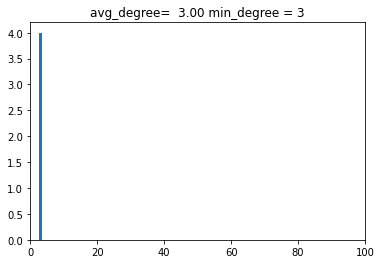

In [8]:
from statistics import median,mean
import numpy as np
import matplotlib.pyplot as plt
hist = nx.degree_histogram(G)
avg_degree = sum(dict(G.degree()).values()) / len(G)
min_degree = min(dict(G.degree()).values())

# plot the histogram
plt.bar(range(len(hist)), hist)
plt.xlim(0,100)
plt.title(f'{avg_degree= : .2f} {min_degree = }')

year
2007    2294
Name: u, dtype: int64

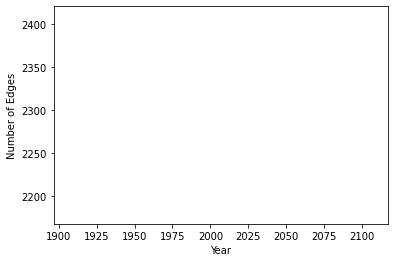

year
1996    446
Name: u, dtype: int64

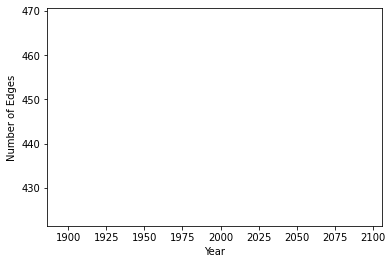

year
1985    12
Name: u, dtype: int64

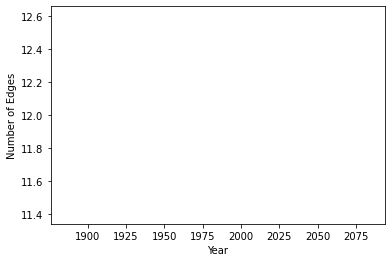

year
2005    1867
Name: u, dtype: int64

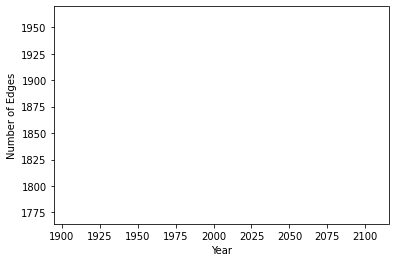

year
1986    136
Name: u, dtype: int64

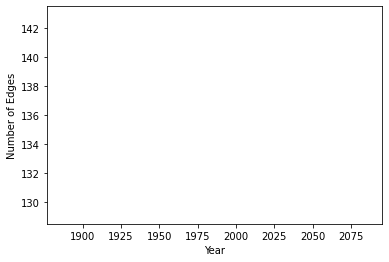

year
1988    39
Name: u, dtype: int64

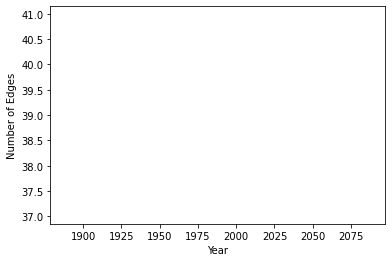

year
1995    69
Name: u, dtype: int64

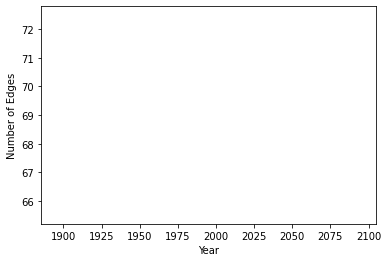

year
1998    667
Name: u, dtype: int64

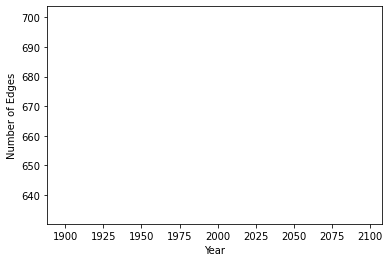

year
1994    215
Name: u, dtype: int64

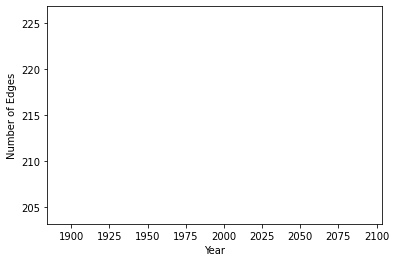

year
1999    365
Name: u, dtype: int64

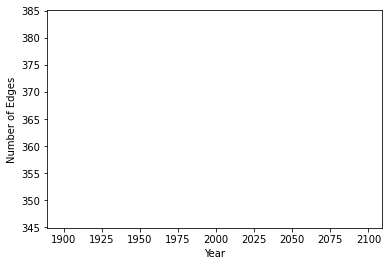

year
1987    21
Name: u, dtype: int64

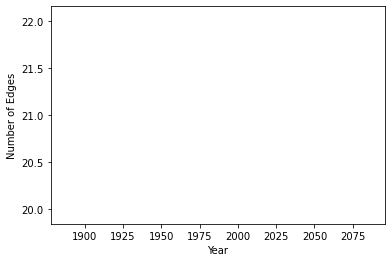

year
1997    194
Name: u, dtype: int64

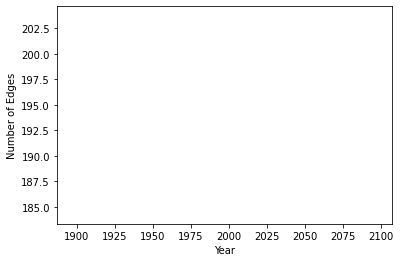

year
2002    329
Name: u, dtype: int64

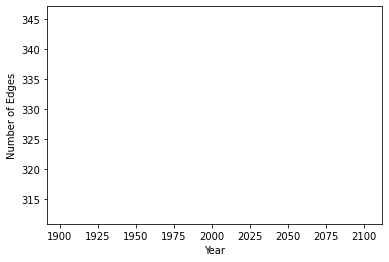

year
2001    732
Name: u, dtype: int64

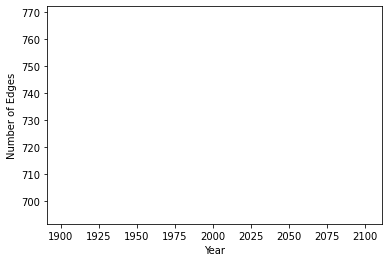

year
1993    85
Name: u, dtype: int64

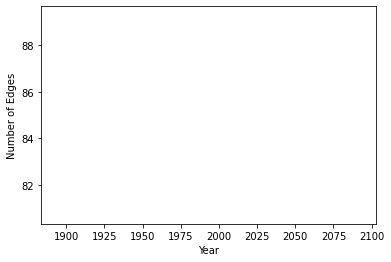

year
1982    21
Name: u, dtype: int64

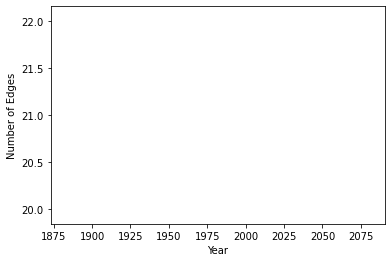

year
2003    1269
Name: u, dtype: int64

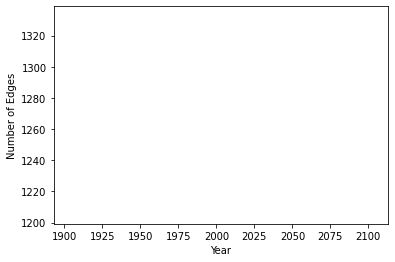

year
2000    268
Name: u, dtype: int64

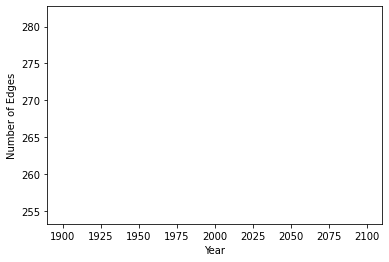

year
2008    3944
Name: u, dtype: int64

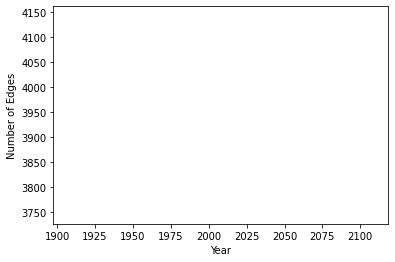

year
2004    1571
Name: u, dtype: int64

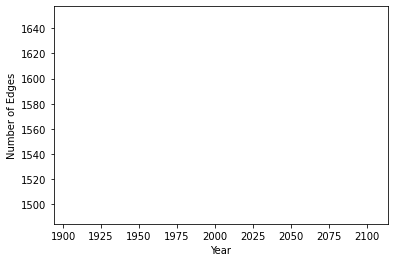

year
2015    8828
Name: u, dtype: int64

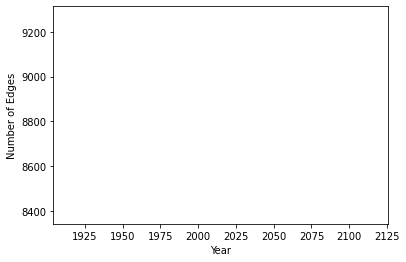

year
2009    4037
Name: u, dtype: int64

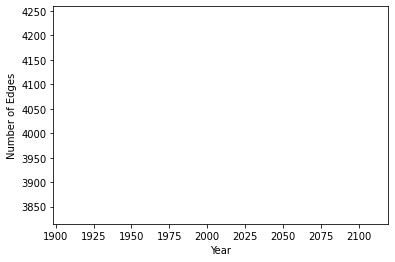

year
2019    28808
Name: u, dtype: int64

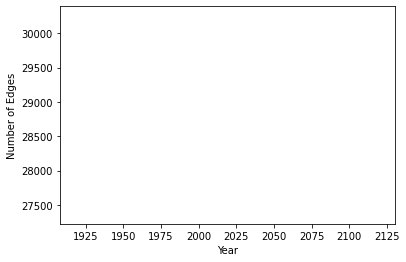

year
2021    85015
Name: u, dtype: int64

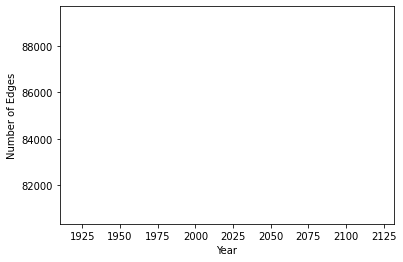

year
1992    41
Name: u, dtype: int64

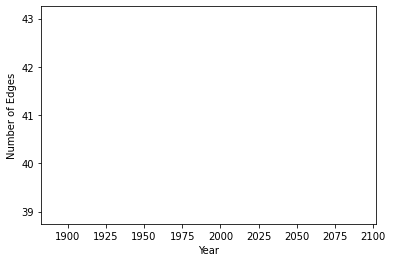

year
2020    49458
Name: u, dtype: int64

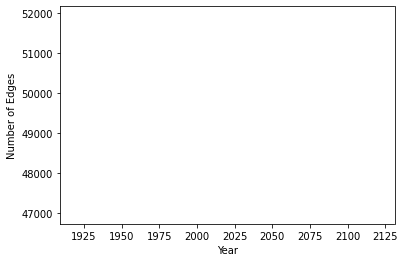

year
2010    3283
Name: u, dtype: int64

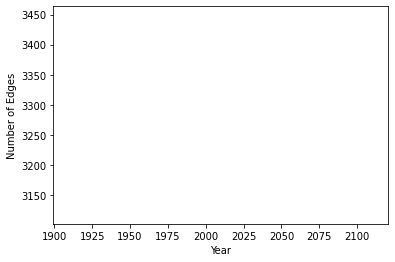

year
2011    3138
Name: u, dtype: int64

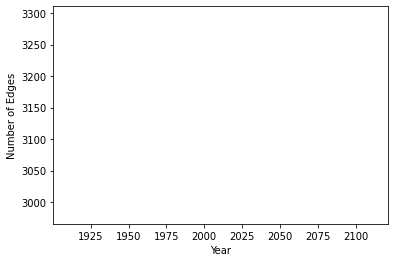

year
2013    6311
Name: u, dtype: int64

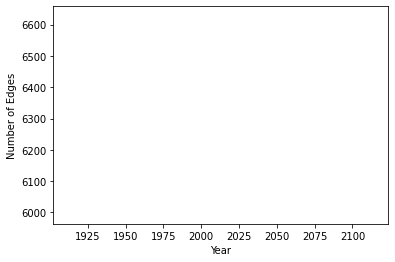

year
2006    1765
Name: u, dtype: int64

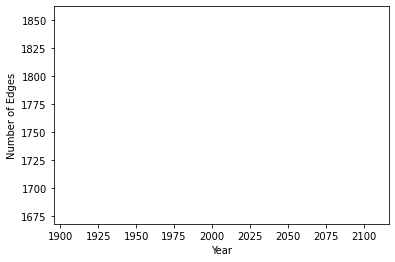

year
2014    7727
Name: u, dtype: int64

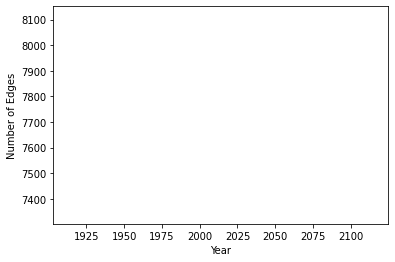

year
1976    3
Name: u, dtype: int64

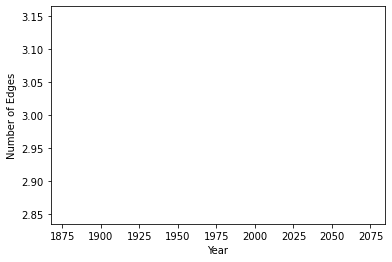

year
1983    28
Name: u, dtype: int64

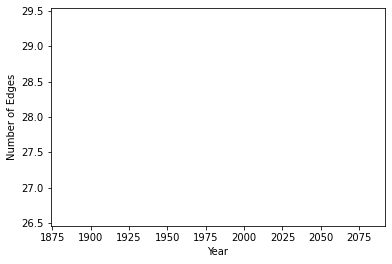

year
2012    3895
Name: u, dtype: int64

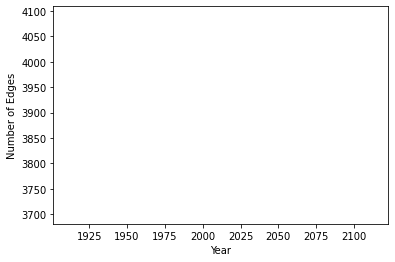

year
1980    37
Name: u, dtype: int64

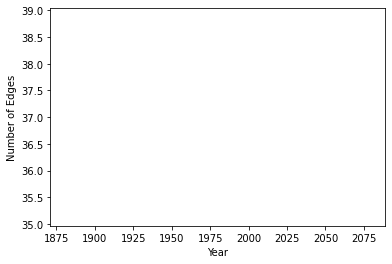

year
1978    27
Name: u, dtype: int64

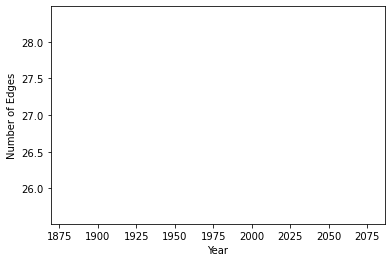

year
1990    75
Name: u, dtype: int64

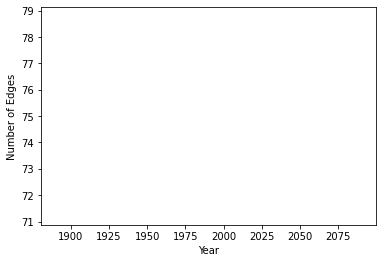

year
1981    10
Name: u, dtype: int64

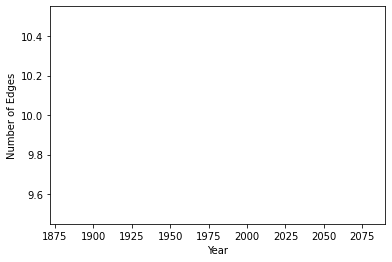

year
2018    21298
Name: u, dtype: int64

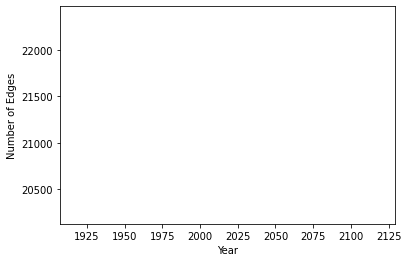

year
1984    136
Name: u, dtype: int64

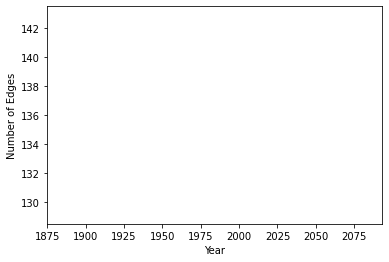

year
1989    164
Name: u, dtype: int64

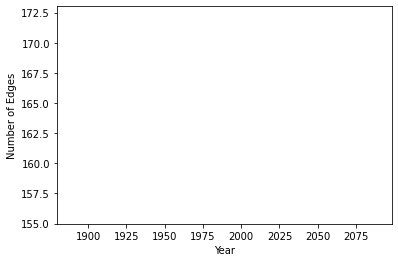

year
1991    116
Name: u, dtype: int64

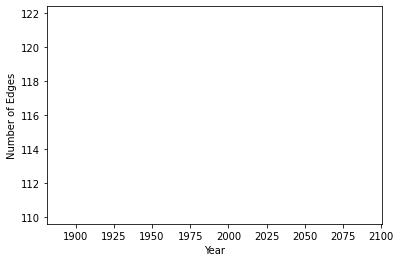

year
2016    10273
Name: u, dtype: int64

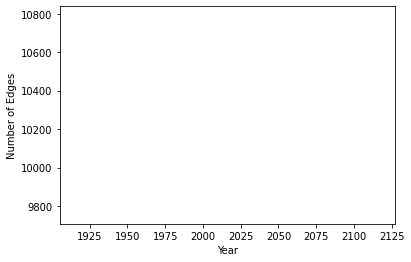

year
1975    7
Name: u, dtype: int64

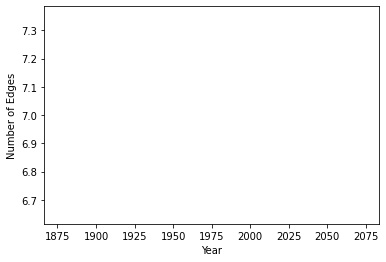

year
1979    120
Name: u, dtype: int64

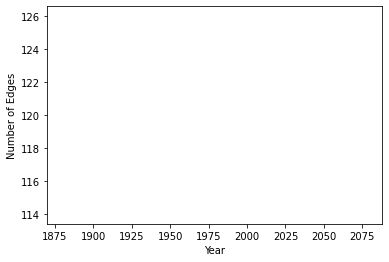

year
1977    37
Name: u, dtype: int64

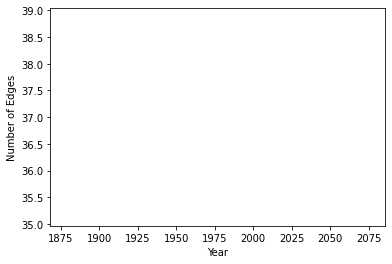

year
1970    3
Name: u, dtype: int64

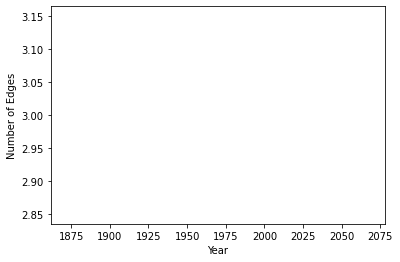

year
1974    6
Name: u, dtype: int64

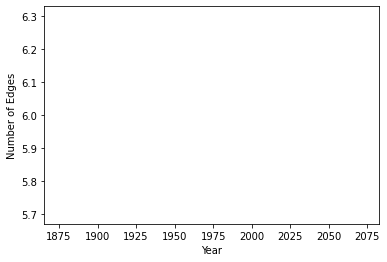

year
2017    7850
Name: u, dtype: int64

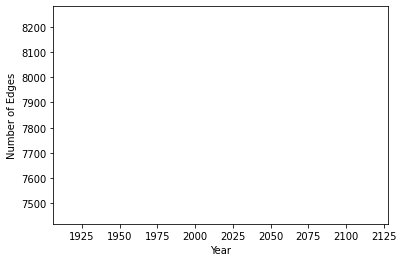

year
1971    1
Name: u, dtype: int64

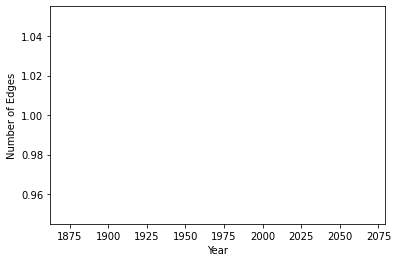

year
0    6
Name: u, dtype: int64

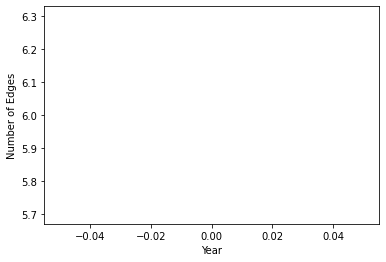

year
2022    41656
Name: u, dtype: int64

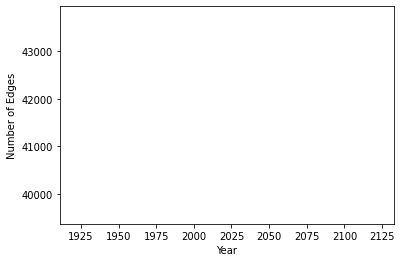

year
2023    111
Name: u, dtype: int64

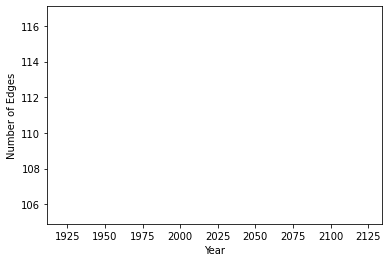

In [9]:
from IPython.display import display

import pandas as pd
for ts in Gs.keys():
    # create a dataframe from the edges
    df = pd.DataFrame(Gs[ts].edges(data=True), columns=['u', 'v', 'attr'])

    # extract the year from the attribute dictionary
    df['year'] = df['attr'].apply(lambda x: x['year'][0])
    # group the edges by year and count them
    edge_count = df.groupby('year').count()['u']
    display(edge_count)

    # plot the edge count by year
    plt.plot(edge_count.index, edge_count.values)
    plt.xlabel('Year')
    plt.ylabel('Number of Edges')
    plt.show()

In [189]:
years = sorted(set([x[0] for x in nx.get_edge_attributes(G, 'year').values()]))

# Group the years into groups of 3
year_groups = [years[i:i+6] for i in range(0, len(years), 6)]
print(f"==>> {year_groups=}")

subgraphs = {}
for group in year_groups:
    # Compute the edges within the current year group
    edges = [(u, v) for u, v, attrs in G.edges(data=True) if attrs['year'][0] in group]


    # Compute the subgraph using the edges within the current year group
    subgraph = G.edge_subgraph(edges) 


    # Get the largest connected component in the subgraph
    largest_cc = max(nx.connected_components(subgraph), key=len)
    print(f"==>> {([len(x) for x in largest_cc])=}")

    # Store the subgraph in a dictionary with the group of years as the key
    subgraphs[tuple(group)] = subgraph.subgraph(largest_cc)

# # If there are any leftover years that don't form a complete group of 3, include them in a final subgraph
# if len(years) % 3 != 0:
#     edges = [(u, v) for u, v, attrs in G.edges(data=True) if attrs['year'] >= years[-1]]
#     subgraph = G.edge_subgraph(edges)
#     largest_cc = max(nx.connected_components(subgraph), key=len)
#     subgraphs[tuple(years[-(len(years) % 3):])] = subgraph.subgraph(largest_cc)


==>> year_groups=[[1984, 1986, 1987, 1988, 1989, 1990], [1991, 1992, 1993, 1994, 1995, 1996], [1997, 1998, 1999, 2000, 2001, 2002], [2003, 2004, 2005, 2006, 2007, 2008], [2009, 2010, 2011, 2012, 2013, 2014], [2015, 2016]]
==>> ([len(x) for x in largest_cc])=[14, 16, 14, 15, 16, 16, 13, 12]
==>> ([len(x) for x in largest_cc])=[26, 12, 17, 13, 17, 16, 13, 14, 12, 13, 16, 13, 18, 16, 15, 13, 14, 16, 15, 11, 16, 6, 16, 12, 26, 23, 8, 15, 14, 12, 16, 16, 12, 17, 15]
==>> ([len(x) for x in largest_cc])=[17, 18, 19, 17, 12, 17, 16, 15, 13, 19, 17, 11, 16, 13, 15, 18, 8, 19, 10, 15, 20, 13, 10, 18, 9, 24, 13, 16, 12, 10, 18, 16, 13, 11, 10, 13, 14, 10, 11, 13, 15, 13, 16, 8, 19, 13, 15, 20, 13, 14, 18, 21, 12, 15, 17, 17, 9, 14, 17, 14]
==>> ([len(x) for x in largest_cc])=[23, 9, 23, 16, 15, 12, 11, 17, 12, 9, 15, 15, 17, 18, 14, 16, 19, 13, 13, 17, 15, 18, 11, 13, 19, 15, 15, 7, 10, 15, 14, 10, 9, 14, 8, 17, 16, 16, 14, 10, 10, 15, 13, 11, 14, 11, 7, 16, 11, 11, 12, 14, 10, 20, 16, 15, 13, 10

In [177]:
years = set([x[0] for x in nx.get_edge_attributes(G, 'year').values()])
subgraphs = {}
for year in years:

    edges = [(u, v) for u, v, attrs in G.edges(data=True) if attrs['year'] == [year]]

    subgraph = G.edge_subgraph(edges) 
    largest_cc = max(nx.connected_components(subgraph), key=len)
    print(([len(x) for x in nx.connected_components(subgraph)]))
    subgraphs[year] = subgraph

[3]
[6, 2, 4, 6, 2]
[3, 3, 2, 2]
[4, 2, 2, 3, 3, 4, 2, 3, 2, 3, 4, 2, 2, 2, 2, 2, 2, 3, 3, 2, 4]
[3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
[4, 5, 4, 2, 2, 3, 2, 2, 4, 2, 3, 2, 3, 2]
[7, 2, 7, 2, 4, 3, 2, 2, 5, 2, 4, 3, 4, 2, 2, 2, 3, 3, 4, 3]
[3, 2, 9, 3, 3, 2, 8, 3, 2, 7, 3, 3, 3, 2, 2, 2, 2, 5, 2, 2, 2, 3]
[2, 4, 6, 3, 2, 2, 3, 4, 4, 4, 3, 3, 3, 2, 2, 4, 2, 2, 2, 2]
[6, 3, 3, 5, 2, 2, 3, 3, 5, 5, 5, 4, 4, 2, 5, 3, 2, 4, 2, 4, 2, 3, 4, 3, 2, 3, 3, 2, 2]
[7, 3, 2, 4, 3, 3, 2, 2, 4, 5, 4, 3, 3, 5, 2, 2, 3, 4, 4, 2, 2, 3, 2, 3, 2, 3, 5, 2, 2, 3, 2, 2, 2, 2]
[3, 10, 8, 2, 2, 3, 3, 2, 2, 3, 2, 2, 6, 4, 5, 2, 2, 5, 2, 5, 2, 9, 2, 2, 3, 2, 6, 3, 3, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2]
[3, 4, 4, 3, 3, 6, 3, 2, 3, 6, 4, 3, 2, 2, 2, 3, 2, 2, 3, 3, 4, 3, 4, 2, 5, 3, 5, 2, 3, 2, 2, 3, 3, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2]
[2, 5, 2, 6, 4, 2, 2, 2, 2, 3, 2, 2, 2, 4, 3, 2, 5, 2, 3, 3, 2, 3, 2, 2, 2, 4, 3, 4, 2, 3, 2]
[3, 2, 2, 2, 9, 2, 3, 3, 2, 4, 3, 5, 2, 2, 3, 4, 2, 2, 3, 2, 2, 3, 2, 9, 6, 3, 

In [12]:
import pandas as pd
# Convert the graph to a Pandas DataFrame
dfs = []
subgraphs = Gs
for i,year in  enumerate(sorted(list(subgraphs.keys()))[-7:-1]):
    s = subgraphs[year]
    # print(s.nodes(data=True))
    df = nx.to_pandas_edgelist(s)
    # print(s[x])
    df['src_label'] = df.source.apply(lambda x: (s.nodes.get(x)['venue']))
    df['len_src'] = df.source.apply(lambda x: (len(s.nodes.get(x)['venue'])))
    df['dest_label'] = df.target.apply(lambda x: (s.nodes.get(x)['venue']))
    df['src_target'] = df.target.apply(lambda x: (len(s.nodes.get(x)['venue'])))
    df['year'] = df.year.apply(lambda x: x[0])
    # display(df)
    dfs.append(df)
   
out = pd.concat(dfs)
node_set = set(out.source) | set(out.target)
node_map = {x:i for i ,x in enumerate(node_set)}
out['u'] = out.source.apply(lambda x: node_map[x])
out['i'] = out.target.apply(lambda x: node_map[x])
display(out.head(20))



,source,target,year,src_label,len_src,dest_label,src_target,u,i
0,,Evaggelia Pitoura,2017,Data Engineering/Management Systems,35,Data Engineering/Management Systems,35,0,11500
1,,Panayiotis Tsaparas,2017,Data Engineering/Management Systems,35,Data Engineering/Management Systems,35,0,31579
2,,Giorgos Flouris,2017,Data Engineering/Management Systems,35,Data Engineering/Management Systems,35,0,18503
3,,Irini Fundulaki,2017,Data Engineering/Management Systems,35,Data Engineering/Management Systems,35,0,23127
4,,Panagiotis Papadakos,2017,Data Engineering/Management Systems,35,Data Engineering/Management Systems,35,0,17087
5,,Serge Abiteboul,2017,Data Engineering/Management Systems,35,Data Engineering/Management Systems,35,0,39032
6,,Gerhard Weikum,2017,Data Engineering/Management Systems,35,Data Engineering/Management Systems,35,0,18752
7,Moojin Chae,Jianguo Wang,2017,Data Engineering/Management Systems,35,Data Engineering/Management Systems,35,30783,1594
8,Moojin Chae,Chunbin Lin,2017,Data Engineering/Management Systems,35,Data Engineering/Management Systems,35,30783,3299
9,Moojin Chae,Ruining He,2017,Data Engineering/Management Systems,35,Data Engineering/Management Systems,35,30783,25568


In [1]:
import pandas as pd 
out = pd.read_csv('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/to_zip/edge_citation.csv',index_col = [0])
mapper = {0:'Artificial Intellegence', 1 :'Data Mining' , 2 :'Data Engineering/Management'}
out.src_label = out.src_label.apply(mapper.get)
out.dest_label = out.dest_label.apply(mapper.get)
print(out.groupby(['year','src_label']).count().source.to_latex())

\begin{tabular}{llr}
\toprule
     &             &  source \\
year & src\_label &         \\
\midrule
2017 & Artificial Intellegence &    3779 \\
     & Data Engineering/Management &    2619 \\
     & Data Mining &    1445 \\
2018 & Artificial Intellegence &    7355 \\
     & Data Engineering/Management &   10741 \\
     & Data Mining &    3118 \\
2019 & Artificial Intellegence &    5407 \\
     & Data Engineering/Management &   20425 \\
     & Data Mining &    2970 \\
2020 & Artificial Intellegence &   10426 \\
     & Data Engineering/Management &   34211 \\
     & Data Mining &    4821 \\
2021 & Artificial Intellegence &   11342 \\
     & Data Engineering/Management &   65516 \\
     & Data Mining &    8157 \\
2022 & Artificial Intellegence &   14568 \\
     & Data Engineering/Management &   21540 \\
     & Data Mining &    5543 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_11178/917547464.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(out.groupby(['year','src_label']).count().source.to_latex())


In [2]:
import matplotlib.pyplot as plt
grouped = out.groupby(['src_label','year','dest_label']).count()
grouped


source  target  \
src_label                   year dest_label                                    
Artificial Intellegence     2017 Artificial Intellegence        3379    3386   
                                 Data Engineering/Management     164     164   
                                 Data Mining                     236     236   
                            2018 Artificial Intellegence        6476    6476   
                                 Data Engineering/Management     458     458   
                                 Data Mining                     421     421   
                            2019 Artificial Intellegence        4262    4262   
                                 Data Engineering/Management     802     802   
                                 Data Mining                     343     343   
                            2020 Artificial Intellegence        8742    8742   
                                 Data Engineering/Management    1170    1170   
                                 Data Mining                     514     514   
                            2021 Artificial Intellegence        7968    7968   
                                 Data Engineering/Management    2062    2062   
                                 Data Mining                    1312    1312   
                            2022 Artificial Intellegence       11854   11854   
                                 Data Engineering/Management    1403    1403   
                                 Data Mining                    1311    1311   
Data Engineering/Management 2017 Artificial Intellegence         165     165   
                                 Data Engineering/Management    2319    2319   
                                 Data Mining                     135     135   
                            2018 Artificial Intellegence         552     568   
                                 Data Engineering/Management    9798    9862   
                                 Data Mining                     391     395   
                            2019 Artificial Intellegence         762     762   
                                 Data Engineering/Management   19074   19079   
                                 Data Mining                     589     589   
                            2020 Artificial Intellegence         917     917   
                                 Data Engineering/Management   32616   32616   
                                 Data Mining                     678     678   
                            2021 Artificial Intellegence        1834    1834   
                                 Data Engineering/Management   60329   60329   
                                 Data Mining                    3353    3353   
                            2022 Artificial Intellegence        2119    2119   
                                 Data Engineering/Management   17449   17446   
                                 Data Mining                    1972    1972   
Data Mining                 2017 Artificial Intellegence         227     227   
                                 Data Engineering/Management     120     120   
                                 Data Mining                    1098    1098   
                            2018 Artificial Intellegence         572     572   
                                 Data Engineering/Management     391     391   
                                 Data Mining                    2155    2155   
                            2019 Artificial Intellegence         336     336   
                                 Data Engineering/Management     658     658   
                                 Data Mining                    1976    1976   
                            2020 Artificial Intellegence         510     510   
                                 Data Engineering/Management     746     746   
                                 Data Mining                    3565    3565   
                            2021 Artificial Intellegence      

In [33]:
vens = grouped.reset_index().src_label.unique()


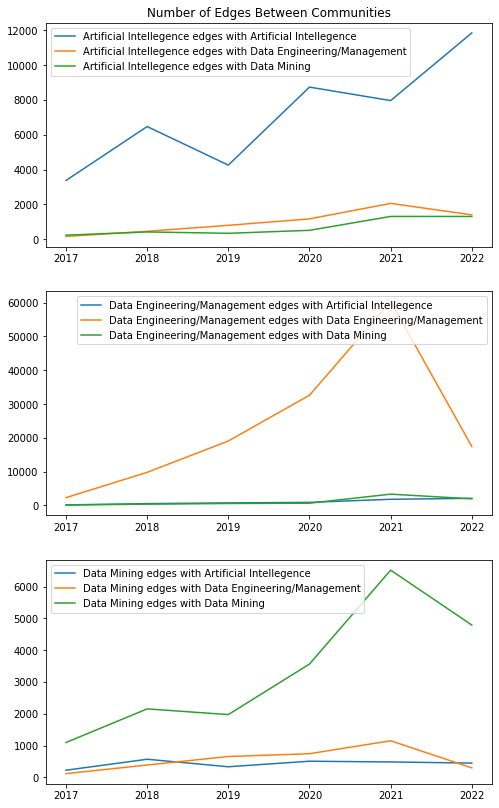

In [34]:
fig ,ax = plt.subplots(3,1,figsize = (8,14))
for i,v in enumerate(vens):
    a = ax.flatten()[i]
    for v1 in vens:
        subset  = grouped.loc[v].reset_index()
        subset = subset[subset.dest_label == v1][['year', 'source']]
        a.plot(subset.year , subset.source, label =f'{v} edges with {v1}' )
        if i == 0:
            a.set_title('Number of Edges Between Communities')
        a.legend()

==>> range(2015,2022,6)=range(2015, 2022, 6)


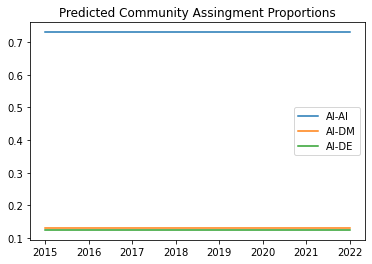

In [51]:
plt.title('Predicted Community Assingment Proportions')
r = list(range(2015,2023,1))
print(f"==>> {range(2015,2022,6)=}")
plt.plot(r, [.73 for x in range(8)], label = 'AI-AI')
plt.plot(r, [.13 for x in range(8)],label  = 'AI-DM')
plt.plot(r, [.125 for x in range(8)],label = 'AI-DE')
plt.legend()

<AxesSubplot:xlabel='src_label,year,dest_label'>

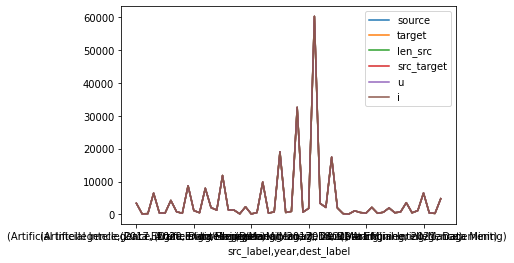

In [11]:
grouped.plot()

In [ ]:
grouped.loc['Artificial Intellegence']

In [4]:
grouped.loc['Artificial Intellegence',]

,source,target,len_src,dest_label,src_target,u,i
year,,,,,,,
2017,3779,3786,3786,3786,3786,3786,3786
2018,7355,7355,7355,7355,7355,7355,7355
2019,5407,5407,5407,5407,5407,5407,5407
2020,10426,10426,10426,10426,10426,10426,10426
2021,11342,11342,11342,11342,11342,11342,11342
2022,14568,14568,14568,14568,14568,14568,14568


In [15]:
label_map = {x: i for i,x in enumerate(out.src_label.unique())}
out.src_label = out.src_label.apply(label_map.get)
out.dest_label = out.dest_label.apply(label_map.get)

In [16]:
out

,source,target,year,src_label,len_src,dest_label,src_target,u,i
0,,Evaggelia Pitoura,2017,0,35,0,35,0,11500
1,,Panayiotis Tsaparas,2017,0,35,0,35,0,31579
2,,Giorgos Flouris,2017,0,35,0,35,0,18503
3,,Irini Fundulaki,2017,0,35,0,35,0,23127
4,,Panagiotis Papadakos,2017,0,35,0,35,0,17087
...,...,...,...,...,...,...,...,...,...
41651,Tenindra Abeywickrama,Victor Liang,2022,0,35,0,35,1770,36341
41652,Gábor E. Gévay,Lorand Madai-Tahy,2022,0,35,0,35,1573,15178
41653,Edo Liberty,Justin Thaler,2022,0,35,0,35,25615,15689
41654,Edo Liberty,Pavel Veselý,2022,0,35,0,35,25615,6751


In [17]:
out.groupby('src_label').count().sort_values('target',ascending=False)

,source,target,year,len_src,dest_label,src_target,u,i
src_label,,,,,,,,
2,155147,155147,155147,155147,155147,155147,155147,155147
0,52884,52884,52884,52884,52884,52884,52884,52884
1,26054,26054,26054,26054,26054,26054,26054,26054


In [18]:
out.to_csv('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/to_zip/edge_citation.csv')

In [26]:
out.year.unique()

array([2017, 2018, 2019, 2020, 2021, 2022])

## Generate Citation Data

In [19]:
import ast
import pandas as pd
df = pd.read_csv('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/to_zip/edge_citation.csv')
df.src_label = df.src_label
df.dest_label = df.dest_label

In [20]:
df.year.unique()

array([2017, 2018, 2019, 2020, 2021, 2022])

In [21]:
dst_df =df[['target','year','dest_label']]
dst_df = dst_df.rename(columns = {'target':'source' , 'dest_label' : 'src_label'})
src_df = df[['source','year','src_label']]

df = pd.concat([dst_df,src_df],axis=0)

In [22]:
exploded = df.explode('src_label') 
confs = ['Data Mining and Knowledge Discovery']
# exploded[exploded.src_label.str.contains('Neural Information Processing Systems')]

In [23]:
from tqdm import tqdm
from IPython.display import display
# dfs = []
label_df = []
timestamps =sorted(df.year.unique())[-7:-1]
print(f"==>> {df.year.unique()=}")
print(f"==>> {timestamps=}")
for ts in tqdm(timestamps):
    exploded = df[df.year == ts].explode('src_label')
    exploded = exploded.drop(exploded[ exploded['src_label']== ''].index)
    label_counts = exploded['src_label'].value_counts()


    # create a boolean mask to identify the labels that appear less than 40 times
    # mask = label_counts < 30 

    # filter out the rows with those labels using the boolean mask
    # df_filtered = exploded.loc[~exploded['src_label'].isin(label_counts.index[mask])]

    label_counts = exploded.groupby('source')['src_label'].value_counts()

    # dfs.append(df_filtered)

    user_to_label = {}
    for user in label_counts.index.levels[0]:
        user_to_label[user] = label_counts[user].idxmax()
    data = []
    for user, label in user_to_label.items():
        data.append({'user': user, 'label': label,'year':ts})
    df_new = pd.DataFrame(data)
    label_df.append(df_new)
    print(f'{len(df_new)=} at year {ts}')
    

# df_stack = pd.concat(dfs,axis = 0)
label_stack = pd.concat(label_df,axis = 0 )

==>> df.year.unique()=array([2017, 2018, 2019, 2020, 2021, 2022])
==>> timestamps=[2017, 2018, 2019, 2020, 2021]


 20%|██        | 1/5 [00:01<00:06,  1.59s/it]

len(df_new)=2496 at year 2017


 40%|████      | 2/5 [00:03<00:05,  1.88s/it]

len(df_new)=6555 at year 2018


 60%|██████    | 3/5 [00:06<00:04,  2.36s/it]

len(df_new)=8775 at year 2019


 80%|████████  | 4/5 [00:10<00:02,  2.81s/it]

len(df_new)=11259 at year 2020


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

len(df_new)=20179 at year 2021


In [115]:
import pickle as pkl
venues = ['neural information processing systems','international conference on machine learning', 'Transactions on Pattern Analysis and Machine Intelligence','Neural Networks','knowledge discovery and data mining','international conference on data mining','Data Mining and Knowledge Discovery',
          'international conference on data engineering','Transactions on Knowledge and Data Engineering','Transactions on Database Systems', 'information system']
venu_map = {'neural information processing systems': 0 ,'international conference on machine learning':0 , 'Transactions on Pattern Analysis and Machine Intelligence': 0 ,
            'Neural Networks':0 , 'knowledge discovery and data mining':1,'international conference on data mining':1,'Data Mining and Knowledge Discovery':1,
            'international conference on data engineering':2,'Transactions on Knowledge and Data Engineering':2,'Transactions on Database Systems':2, 'information system':2}
with open('label_mapper.pkl','wb+') as f:
    pkl.dump(venu_map,f)
label_stack.label = label_stack.label.apply(venu_map.get)

In [24]:
import pandas as pd 
df = pd.read_csv('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/to_zip/edge_citation.csv')

In [25]:
subset_df_list = []
label_stack_adjusted = []

for ts in label_stack.year.unique():
    target_ids = set(label_stack[label_stack.year == ts].user) 

    cur_df = df[(df.year == ts) &(df.source.isin(target_ids)) & (df.target.isin(target_ids))]
    cur_df_set = set(cur_df.source) | set(cur_df.target)
  
    subset_df_list.append(df[(df.year == ts) &(df.source.isin(target_ids)) & (df.target.isin(target_ids))])
    label_stack_adjusted.append(label_stack[(label_stack.year == ts) & (label_stack.user.isin(cur_df_set))])






In [26]:
sub_df = pd.concat(subset_df_list)
label_stack= pd.concat(label_stack_adjusted)

In [27]:
node_set = set(label_stack.user)
node_map = {x:i for i,x in enumerate(node_set)}
label_stack_mapped = label_stack.copy()
label_stack_mapped.user = label_stack.user.apply(node_map.get)


In [96]:
!ls processed_data/

ls: cannot access 'processed_data/': No such file or directory


In [28]:
label_stack_mapped.to_csv('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/processed_data/Citation/labels.csv',index = False)


In [29]:

sub_df.u = sub_df.source.apply(node_map.get)
sub_df.i = sub_df.target.apply(node_map.get)
sub_df['ts'] = sub_df.year
sub_df['idx'] = (range(len(sub_df)))
sub_df['label'] = [0 for _ in range(len(sub_df))]

In [30]:
sub_df=sub_df[['u','i','ts','idx','label']]

In [31]:
import numpy as np

node_feats = np.zeros(len(node_set))
edge_feats = np.ones(len(sub_df))


np.save('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/processed_data/Citation/ml_Citation_node.npy',node_feats.reshape((-1,1)))

np.save('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/processed_data/Citation/ml_Citation.npy',edge_feats.reshape(-1,1))

sub_df.to_csv('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/processed_data/Citation/ml_Citation.csv')

In [32]:
for i in label_stack.year.unique():
    print(f"==>> {len(set(label_stack[label_stack.year == i ].user))=}")
    print(f"==>> {(len(set(sub_df[sub_df.ts == i].u) | set(sub_df[sub_df.ts == i].i)) == len(set(label_stack[label_stack.year == i ].user)) )=}")

==>> len(set(label_stack[label_stack.year == i ].user))=2496
==>> (len(set(sub_df[sub_df.ts == i].u) | set(sub_df[sub_df.ts == i].i)) == len(set(label_stack[label_stack.year == i ].user)) )=True
==>> len(set(label_stack[label_stack.year == i ].user))=6555
==>> (len(set(sub_df[sub_df.ts == i].u) | set(sub_df[sub_df.ts == i].i)) == len(set(label_stack[label_stack.year == i ].user)) )=True
==>> len(set(label_stack[label_stack.year == i ].user))=8775
==>> (len(set(sub_df[sub_df.ts == i].u) | set(sub_df[sub_df.ts == i].i)) == len(set(label_stack[label_stack.year == i ].user)) )=True
==>> len(set(label_stack[label_stack.year == i ].user))=11259
==>> (len(set(sub_df[sub_df.ts == i].u) | set(sub_df[sub_df.ts == i].i)) == len(set(label_stack[label_stack.year == i ].user)) )=True
==>> len(set(label_stack[label_stack.year == i ].user))=20179
==>> (len(set(sub_df[sub_df.ts == i].u) | set(sub_df[sub_df.ts == i].i)) == len(set(label_stack[label_stack.year == i ].user)) )=True


# Interpret Embeddings 

In [50]:
import pandas as pd
d = pd.read_csv('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/output_clusters/compare_tgat_4.csv')

In [39]:
d[d.preds == 0]

,labels,preds
82,0,0
84,1,0
100,0,0
132,0,0
144,0,0
...,...,...
2434,2,0
2457,2,0
2467,2,0
2469,2,0


In [51]:
for i in range(3):
    for j in range(3):
        print(f'{j=} , {i=}')
        print(len(d[(d.labels == j) & (d.preds==i)])/len(d[d.labels == j]))

j=0 , i=0
0.3548661283467913
j=1 , i=0
0.34845814977973566
j=2 , i=0
0.37696065826690667
j=0 , i=1
0.2362940926476838
j=1 , i=1
0.22819383259911893
j=2 , i=1
0.2327076369246593
j=0 , i=2
0.4088397790055249
j=1 , i=2
0.4233480176211454
j=2 , i=2
0.39033170480843404


In [157]:
sum(d.labels == d.preds)/len(d)

0.36711590296495955